# Importation des données

In [14]:
import os
import string
import re
import math
import statistics
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

On ne garde ici que les 100 000 premiers tweets

In [15]:
# Penser à changer selon taille
with open("data/100k/vocabulary.file", "rb") as f:
    taille_vocab = len(pickle.load(f))

In [16]:
# Fonction pour mettre à jour le graphique en direct
def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

# Lancement du modèle
Paramètres fixés : la dimension, le nombre de mots tirés dans le *negative sampling* et la proba utilisé, l'affichage du graphique

In [17]:
dim = 20
plot = True
epoch = 10

Paramètres à modifier :

In [18]:
learning_rate = 0.01
window = 4
numero_simulation = 3

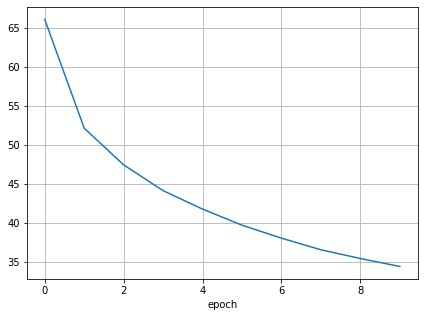

1.83
19.35
1.927780989408493


In [19]:
input = torch.randn(taille_vocab, dim)
output = torch.randn(taille_vocab, dim)
input = autograd.Variable(input, requires_grad=True)
output = autograd.Variable(output, requires_grad=True)

loss_tot = []
temps_par_epoch = []

start = time.time()
for i in range(epoch):
    loss_val = 0
    start_epoch = time.time()
    
    if not os.path.exists("data/100k/Simulation_%i" %numero_simulation):
        os.mkdir("data/100k/Simulation_%i" %numero_simulation)
    else:
        print("Attention : le dossier Simulation_%i existe déjà" %numero_simulation)
    
    print("Lecture du fichier "+ "data/100k/window_%i/" % window + "epoch_%i.file" %i)
    with open("data/100k/window_%i/" % window + "epoch_%i.file" %i, "rb") as f:
        test_sample = pickle.load(f)

    for focus, context, neg_sample in test_sample:
        data = torch.matmul(input[focus,], torch.t(output[context,]))
        loss1 = - F.logsigmoid(data)

        data = torch.matmul(input[focus,], torch.t(output[neg_sample,]))
        loss2 = - F.logsigmoid(-data).sum()
        loss_val += loss1 + loss2
        # Pour ensuite dériver les matrices par rapport à la loss
        (loss1+loss2).backward()

        # Il faut modifier juste le .data pour ne pas perdre la structure
        input.data = input.data - learning_rate * input.grad.data
        output.data = output.data - learning_rate * output.grad.data

        input.grad.data.zero_()
        output.grad.data.zero_()
        
    with open("data/100k/Simulation_%i/" %numero_simulation + "input_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(input, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/Simulation_%i/" %numero_simulation + "output_%i.file" %(len(loss_tot)+1), "wb") as f:
        pickle.dump(output, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/Simulation_%i/" %numero_simulation + "loss.file", "wb") as f:
        pickle.dump(loss_tot, f, pickle.HIGHEST_PROTOCOL)
    with open("data/100k/Simulation_%i/" %numero_simulation + "temps_par_epoch.file", "wb") as f:
        pickle.dump(temps_par_epoch, f, pickle.HIGHEST_PROTOCOL)
        
    end_epoch = time.time()
    temps_par_epoch.append(end_epoch - start_epoch)
    loss_val = loss_val / taille_vocab
    loss_tot.append(loss_val)
    if plot:
        live_plot(loss_tot)
    print(round((end_epoch - start_epoch)/60, 2))
end = time.time()
print(round((end - start)/60, 2))
print(statistics.mean(temps_par_epoch)/60)